# Enron Anaylsis

 In your submission we are looking for:

problem solving skills 
innovative ideas
software engineering skills 
 

To put structure on this challenge, we are expecting to see the following in your submission:

Exploratory Data Analysis
Pre-process/clean up the data if needed
Basic statistics to help understand the dataset
Explore and present initial insights found from the data
Use visualisation tools to help presentation of the insights
 Find an interesting area to further explore the dataset, e.g., topics modelling and clustering
Additional Requirements:

Please present your results in the form of a Jupyter notebook
Create a summary section at the beginning of the notebook and tell us what you are trying to achieve and the implementation plan
The structure of the notebook should clearly show your thought process with suitable comments and narratives (hint: markdown is handy for such purpose)
Your work should be reproducible
Please use Github to share your work with us

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, there was a significant amount of typically confidential information entered into public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement, or plea deal with the government, or testified in exchange for prosecution immunity.

In [1]:
import os, sys, email
import numpy as np 
import pandas as pd
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud

# Network analysis
import networkx as nx
# NLP
from nltk.tokenize.regexp import RegexpTokenizer

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

### Importing of the Inital data set in csv format

In [2]:
df = pd.read_csv("emails.csv")

## Exploratory Data Analysis

In [3]:
df.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


The details of the message are a single object. Therefore we extract the different attributes of the message

In [5]:
print(df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [6]:
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

###  The details from the message are broken up into seperate columns

In [7]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, df['message']))
df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    df[key] = [doc[key] for doc in messages]
# Parse content from emails
df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
df['From'] = df['From'].map(split_email_addresses)
df['To'] = df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
df['user'] = df['file'].map(lambda x:x.split('/')[0])
del messages

df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


### The number of unique values for each of the fields

In [8]:
print('shape of the dataframe:', df.shape)
# Find number of unique values in each columns
for col in df.columns:
    print(col, df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [9]:
# Set index and drop columns with two few values
df = df.set_index('Message-ID')\
    .drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding'], axis=1)
# Parse datetime
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.dtypes

Date          object
From          object
To            object
Subject       object
X-From        object
X-To          object
X-cc          object
X-bcc         object
X-Folder      object
X-Origin      object
X-FileName    object
content       object
user          object
dtype: object

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], utc = True)
ax = df.groupby(df['Date'].dt.year)['content'].count().plot()
ax.set_xlabel('Year', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_xlim(1990,2020)
ax.set_title("Number of emails a year")

Text(0, 0.5, 'N emails')

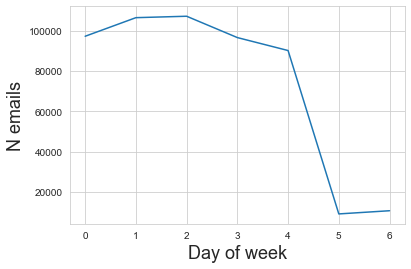

In [13]:
ax = df.groupby(df['Date'].dt.dayofweek)['content'].count().plot()
ax.set_xlabel('Day of week', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_title("Number of emails sent overall on a week")

Text(0, 0.5, 'N emails')

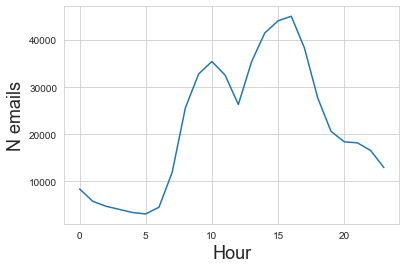

In [14]:
ax = df.groupby(df['Date'].dt.hour)['content'].count().plot()
ax.set_xlabel('Hour', fontsize=18)
ax.set_ylabel('N emails', fontsize=18)
ax.set_title("Number of emails sent on each hour of the day")

## Counting the average number of words in the content of an email and the subject of an email for each user

In [15]:
# Count words in Subjects and content
tokenizer = RegexpTokenizer(r'(?u)\b\w\w+\b')
df['subject_wc'] = df['Subject'].map(lambda x: len(tokenizer.tokenize(x)))
df['content_wc'] = df['content'].map(lambda x: len(tokenizer.tokenize(x)))

In [16]:
grouped_by_people = df.groupby('user').agg({
        'content': 'count', 
        'subject_wc': 'mean',
        'content_wc': 'mean',
    })
grouped_by_people.rename(columns={'content': 'N emails', 
                                  'subject_wc': 'Subject word count', 
                                  'content_wc': 'Content word count'}, inplace=True)
grouped_by_people.sort_values('N emails', ascending=False).head()

,N emails,Subject word count,Content word count
user,,,
kaminski-v,28465,4.217530,255.906025
dasovich-j,28234,5.237373,603.393391
kean-s,25351,4.959331,490.837561
mann-k,23381,4.211796,207.195501
jones-t,19950,4.748221,185.462607


C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\BenSlater\anaconda3\lib\site-packages\seaborn\distributions.p

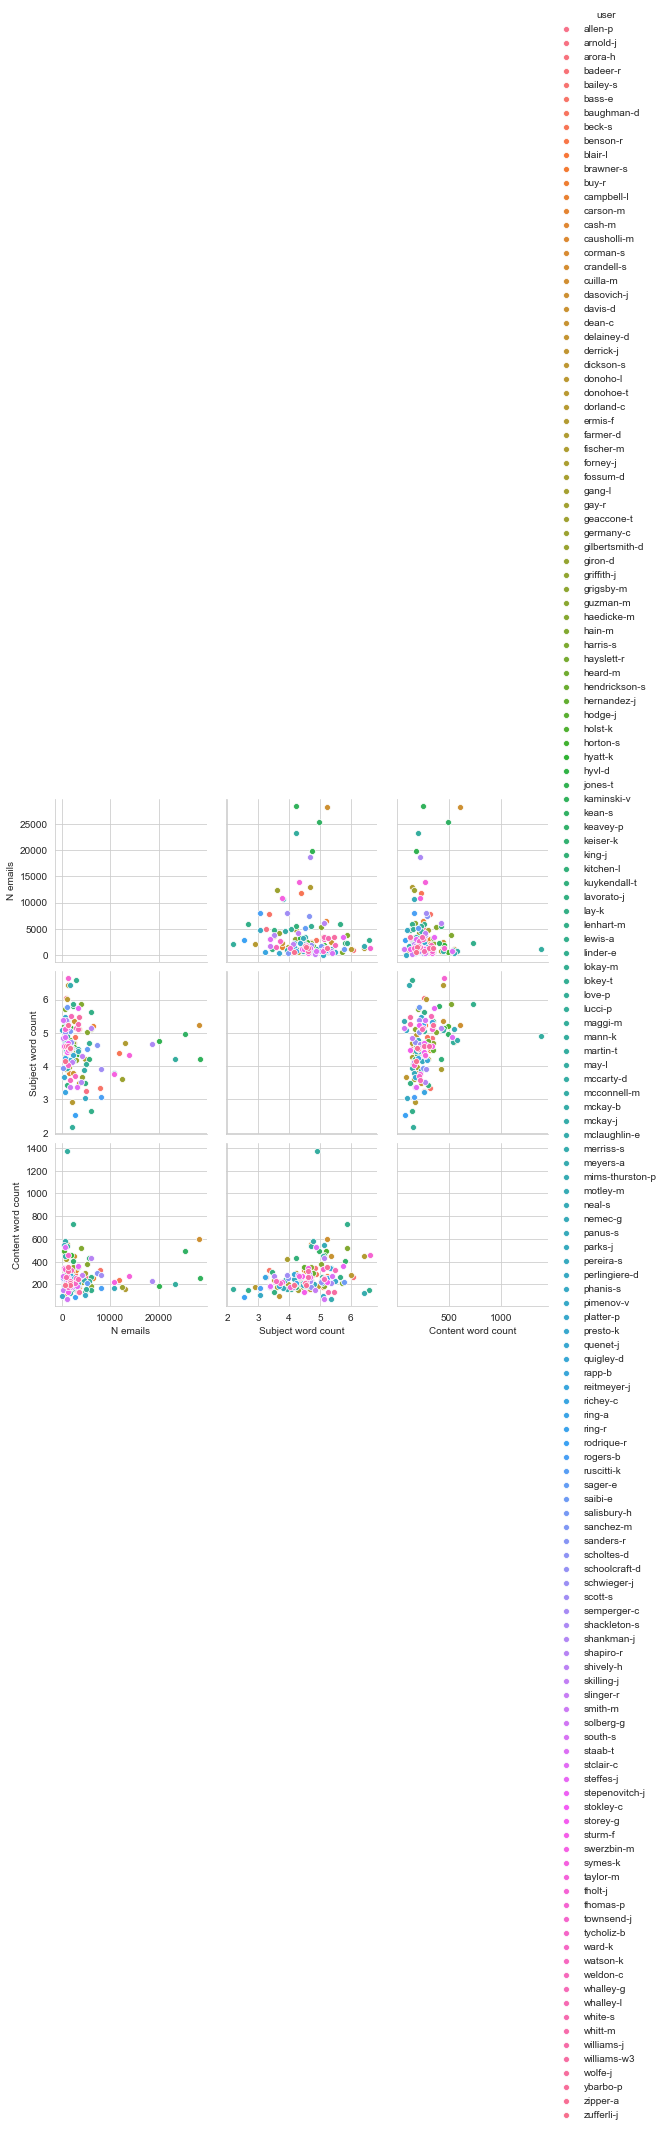

In [17]:
sns.pairplot(grouped_by_people.reset_index(), hue='user')

In [18]:
sub_df = df[['From', 'To', 'Date']].dropna()
print(sub_df.shape)
# drop emails sending to multiple addresses
sub_df = sub_df.loc[sub_df['To'].map(len) == 1]
print(sub_df.shape)

(495554, 3)
(354600, 3)


## The most number of emails sent between two email addresses

In [19]:
sub_df = sub_df.groupby(['From', 'To']).count().reset_index()
# Unpack frozensets
sub_df['From'] = sub_df['From'].map(lambda x: next(iter(x)))
sub_df['To'] = sub_df['To'].map(lambda x: next(iter(x)))
# rename column
sub_df.rename(columns={'Date': 'count'}, inplace=True)
sub_df.sort_values('count', ascending=False).head(10)

,From,To,count
17908,pete.davis@enron.com,pete.davis@enron.com,9141
38033,vince.kaminski@enron.com,vkaminski@aol.com,4308
28920,enron.announcements@enron.com,all.worldwide@enron.com,2206
28935,enron.announcements@enron.com,all.houston@enron.com,1701
26510,kay.mann@enron.com,suzanne.adams@enron.com,1528
38031,vince.kaminski@enron.com,shirley.crenshaw@enron.com,1190
14564,steven.kean@enron.com,maureen.mcvicker@enron.com,1014
26309,kay.mann@enron.com,nmann@erac.com,980
18926,kate.symes@enron.com,evelyn.metoyer@enron.com,915
18930,kate.symes@enron.com,kerri.thompson@enron.com,859


In [21]:
df.head()

,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc
Message-ID,,,,,,,,,,,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,(phillip.allen@enron.com),(tim.belden@enron.com),,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,0,4
<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,1,130
<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2,5
<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,(phillip.allen@enron.com),(randall.gay@enron.com),,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,0,32
<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2,7


# LDA

### Preprocessing the data for LDA
The data corpus is preprocessing by removing speaical chracters, html tags, urls, stopwords, white space, and stemming and lemmitsation of words

In [2]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
from autocorrect import Speller

spell = Speller(lang='en')

def preprocess(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BenSlater\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [43]:
emails_df['cleancontent']=emails_df['content'].map(lambda s:preprocess(s)) 

LookupError: 
**********************************************************************
  Resource [93mwordnet[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('wordnet')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mcorpora/wordnet[0m

  Searched in:
    - 'C:\\Users\\BenSlater/nltk_data'
    - 'C:\\Users\\BenSlater\\anaconda3\\nltk_data'
    - 'C:\\Users\\BenSlater\\anaconda3\\share\\nltk_data'
    - 'C:\\Users\\BenSlater\\anaconda3\\lib\\nltk_data'
    - 'C:\\Users\\BenSlater\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [33]:
import spacy
import re
from tqdm import tqdm
from autocorrect import Speller

In [61]:
!python3 -m spacy download en_core_web_md

Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.


In [35]:
# Load spacy models
spacy.load("en_core_web_md")
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Load spacy models
nlp = spacy.load("en_core_web_md")
spellcheck = Speller(lang='en')

In [ ]:
# Postcode regex for leading area code
postcodeRegex = re.compile("^([A-Z][A-Z]{0,1})") # Regex for extracting PostCode Area

# Captures (in order):
## html tags
## non word symbols
## all but the last white space for places with multiple white space
## one letter words and their leading white space
## all stop words and their leading white space
cleanerRegexString = r"<[^>]+>|[^\w\s]|\s+(?=\s)|(^|\s)\w{1}(?=\s)|(^|\s)" + r"|(^|\s)".join(stopwords)
cleaner = re.compile(cleanerRegexString)

In [4]:
def cleanDescription(desc, minLength=50, maxLength=1000):
    desc = cleaner.sub("", desc.lower()).strip()
    descLen = len(desc)
    if (
        (minLength is not None and descLen < minLength) or # less than 50 characters
        (maxLength is not None and descLen > maxLength)  # more than 1000 characters
        ):
        # If the description isn't long enough simple return None
        return None
    return desc

In [66]:
tqdm.pandas()

C:\Users\BenSlater\anaconda3\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [67]:
emails_df["cleancontent"] = emails_df["content"].progress_apply(cleanDescription)

100%|███████████████████████████████████████████████████████████████████████| 517401/517401 [10:15:34<00:00, 14.01it/s]


In [71]:
emails_df.to_csv("cleaned_emails.csv")

In [70]:
emails_df["cleancontent"][:100]

Message-ID
<18782981.1075855378110.JavaMail.evans@thyme>                                                 None
<15464986.1075855378456.JavaMail.evans@thyme>    traveling businessetings fun trip especiallyf ...
<24216240.1075855687451.JavaMail.evans@thyme>                                                 None
<13505866.1075863688222.JavaMail.evans@thyme>    randyn send schedule salary levelyonen\nschedu...
<30922949.1075863688243.JavaMail.evans@thyme>                                                 None
                                                                       ...                        
<29919154.1075855689201.JavaMail.evans@thyme>    mackssearchport eogere observations gas sales ...
<4511963.1075855689223.JavaMail.evans@thyme>     warded phillipllenhouect 08202000\n0539 pm \nl...
<33111317.1075855689245.JavaMail.evans@thyme>    warded phillipllenhouect 08202000\n0538 pm \nl...
<1665326.1075855689266.JavaMail.evans@thyme>     warded phillipllenhouect 08202000\n0538 pm \nl...

In [23]:
emails_df= pd.read_csv("cleaned_emails.csv")

In [24]:
emails_df.head()

,Message-ID,Date,From,To,Subject,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user,subject_wc,content_wc,cleancontent
0,<18782981.1075855378110.JavaMail.evans@thyme>,2001-05-14 23:39:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'tim.belden@enron.com'}),NaN,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p,0,4,NaN
1,<15464986.1075855378456.JavaMail.evans@thyme>,2001-05-04 20:51:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'john.lavorato@enron.com'}),Re:,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,NaN,NaN,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p,1,130,traveling businessetings fun trip especiallyf ...
2,<24216240.1075855687451.JavaMail.evans@thyme>,2000-10-18 10:00:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'leah.arsdall@enron.com'}),Re: test,Phillip K Allen,Leah Van Arsdall,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p,2,5,NaN
3,<13505866.1075863688222.JavaMail.evans@thyme>,2000-10-23 13:13:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'randall.gay@enron.com'}),NaN,Phillip K Allen,Randall L Gay,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p,0,32,randyn send schedule salary levelyonen\nschedu...
4,<30922949.1075863688243.JavaMail.evans@thyme>,2000-08-31 12:07:00+00:00,frozenset({'phillip.allen@enron.com'}),frozenset({'greg.piper@enron.com'}),Re: Hello,Phillip K Allen,Greg Piper,NaN,NaN,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p,2,7,NaN


In [25]:
len(emails_df)

517401

In [26]:
emails_df['cleancontent'].isna().sum() 

177467

In [29]:
emails_df = emails_df.dropna(subset=['cleancontent'])

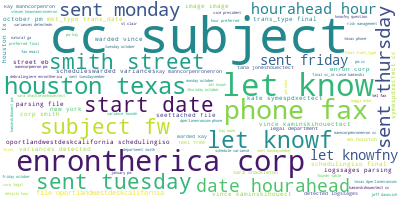

In [30]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(emails_df['cleancontent'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [40]:
def encodeData(df):


    vectors = []
    for doc in tqdm(nlp.pipe(df["cleancontent"].values, batch_size=50)):
        vectors.append(list(doc.vector))

    #df["QTE_Vectors"] = vectors

    df[[str(x)for x in range(300)]] = pd.DataFrame(vectors, index=df.index)
    df.drop(["cleancontent"], axis=1, inplace=True)

    return df
df = encodeData(emails_df)

339934it [39:27, 143.61it/s]


In [43]:
df.to_csv("vectors.csv")

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = papers.paper_text_processed.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

In [ ]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]